## Overview

Perform some analysis of IBD, specifically:

- Plot summaries of IBD data (total IBD, no. tracts), comparing within and between sampling sites.

- Perhaps a network?

In [1]:
%run setup.ipynb

In [2]:
from itertools import combinations
from intervaltree import Interval, IntervalTree
from pathlib import Path

In [3]:
import logging
LOGFORMAT = '%(asctime)s : %(levelname)s : %(message)s'
logging.basicConfig(format=LOGFORMAT, level=logging.INFO, datefmt="%Y-%m-%d %H:%M:%S")


In [4]:
# plotting setup
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
# sns.set_style('darkgrid')
# sns.set_context('paper')
plt.rcParams['figure.dpi'] = 120
%config InlineBackend.figure_formats = {'retina', 'png'}

In [5]:
regions = {
    "3R": (1000000, 37000000),
    "3L": (15000000, 41000000)}

In [6]:
seqs = sorted(regions.keys())

In [7]:
starts = [regions[c][0] for c in seqs]
ends = [regions[c][1] for c in seqs]

In [8]:
seqs, starts, ends

(['3L', '3R'], [15000000, 1000000], [41000000, 37000000])

In [9]:
ibd_data = Path("/kwiat/vector/ag1000g/analysis/20180625-IBD-phase2", "output")

In [10]:
genome = phase2_ar1.genome_agamp3

In [11]:
IBDCOLS = ["sample1", "i1", "sample2", "i2", "chrom", "start", "end", "LOD"]
def load_raw_ibd(seqid, popid, min_chunk_size):
    
    fn = ibd_data / seqid / (popid + ".ibd")
    logging.info("loading {0}".format(fn))
    df = pd.read_table(fn, names=IBDCOLS)
    df["chunk_size"] = df.end - df.start
    return df.query("chunk_size >= @min_chunk_size")

In [12]:
tt = IntervalTree.from_tuples(((100, 140), (160, 200)))

In [13]:
tt.span()

100

In [14]:
Interval.length

<function intervaltree.interval.Interval.length(self)>

In [15]:
def get_IBD(chrom, start, stop, pop, samples, min_size=100000):
        
    if not isinstance(chrom, str):
        f  = {}
        for _c, _s, _e in zip(chrom, start, stop):
            f[_c] = get_IBD(_c, _s, _e, pop, samples, min_size)

        f = pd.concat(f).groupby(level=[1, 2]).aggregate(sum)
        
    else:
        
        ibddf = load_raw_ibd(chrom, pop, min_size)
        all_combs = list(combinations(samples, 2))
        logging.info("Loaded {0} {1}: processing...".format(chrom, pop))
        
        mi = pd.MultiIndex.from_tuples(all_combs, names=["Sample1", "Sample2"])
        f = pd.DataFrame(data=0, index=mi, columns=["IBDsum", "IBDcount"])

        # cut the start and stop
        g = ibddf.groupby(["sample1", "sample2"])
        
        for spair, df in g:
            
            x = df[["start", "end"]]
            tree = IntervalTree.from_tuples(x.to_records(index=False))
                
            tree.chop(1, start)
            tree.chop(stop, len(genome[chrom]))
            f.loc[spair] = sum([iv.length() for iv in tree]), len(tree)
            del tree
        
    return f

In [16]:
ibd_dict = {
    pop: get_IBD(
        seqs, starts, ends,
        pop, 
        sorted(phase2_ar1.df_samples.query("population == @pop").index),
        min_size=0) for pop in phase2_ar1.pop_ids}

2019-04-12 14:34:26 : INFO : loading /kwiat/vector/ag1000g/analysis/20180625-IBD-phase2/output/3L/AOcol.ibd
2019-04-12 14:34:26 : INFO : Loaded 3L AOcol: processing...
2019-04-12 14:34:29 : INFO : loading /kwiat/vector/ag1000g/analysis/20180625-IBD-phase2/output/3R/AOcol.ibd
2019-04-12 14:34:29 : INFO : Loaded 3R AOcol: processing...
2019-04-12 14:34:33 : INFO : loading /kwiat/vector/ag1000g/analysis/20180625-IBD-phase2/output/3L/GHcol.ibd
2019-04-12 14:34:33 : INFO : Loaded 3L GHcol: processing...
2019-04-12 14:34:34 : INFO : loading /kwiat/vector/ag1000g/analysis/20180625-IBD-phase2/output/3R/GHcol.ibd
2019-04-12 14:34:34 : INFO : Loaded 3R GHcol: processing...
2019-04-12 14:34:36 : INFO : loading /kwiat/vector/ag1000g/analysis/20180625-IBD-phase2/output/3L/BFcol.ibd
2019-04-12 14:34:36 : INFO : Loaded 3L BFcol: processing...
2019-04-12 14:34:39 : INFO : loading /kwiat/vector/ag1000g/analysis/20180625-IBD-phase2/output/3R/BFcol.ibd
2019-04-12 14:34:39 : INFO : Loaded 3R BFcol: proces

In [17]:
all_pop_sum = pd.concat(ibd_dict, names=["population"])

In [18]:
all_pop_sum.sort_values("IBDsum", ascending=False).head(10)

IBDsum  IBDcount
population Sample1  Sample2                     
AOcol      AR0042-C AR0049-C  62000000         2
CMgam      AN0142-C AN0169-C  62000000         2
           AN0020-C AN0169-C  62000000         2
           AN0085-C AN0107-C  62000000         2
           AN0147-C AN0179-C  62000000         2
           AN0171-C AN0205-C  62000000         2
           AN0020-C AN0142-C  62000000         2
           AN0124-C AN0183-C  62000000         2
           AN0154-C AN0193-C  62000000         2
           AN0010-C AN0171-C  62000000         2

In [19]:
all_pop_sum["log_IBDsum"] = np.log(all_pop_sum.IBDsum)

/home/njh/git/vector-ops/binder/deps/conda/envs/vector-ops/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


/home/njh/git/vector-ops/binder/deps/conda/envs/vector-ops/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


<Figure size 1440x960 with 0 Axes>

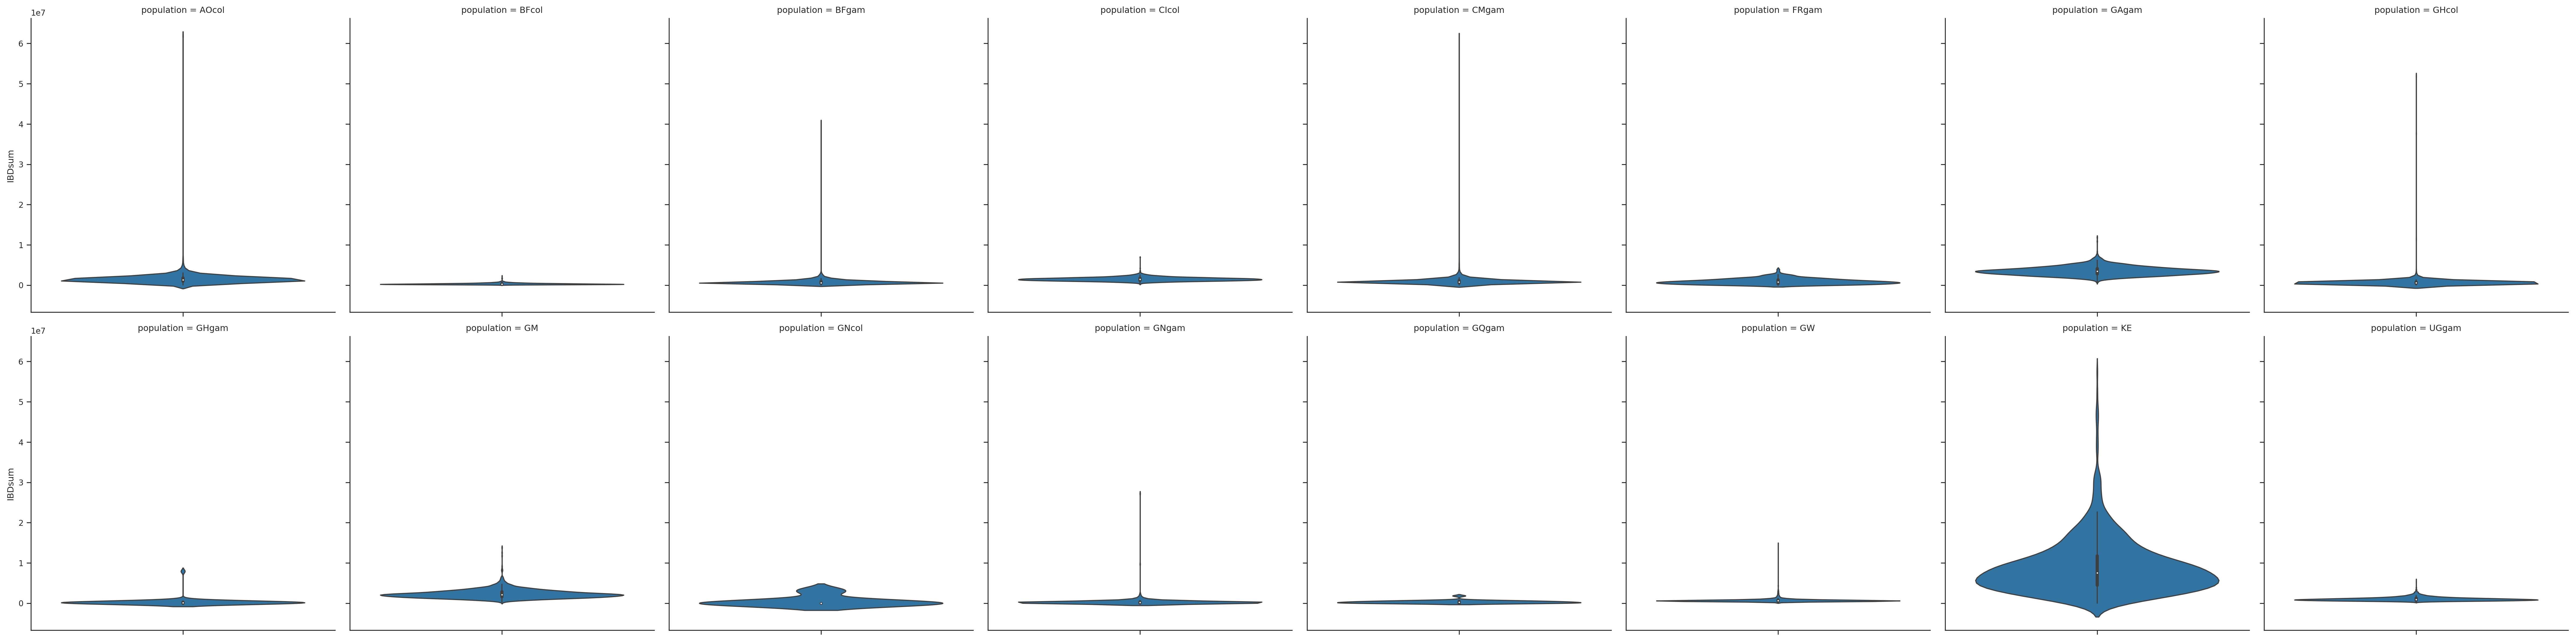

In [20]:
f = plt.figure(figsize=(12, 8))
sns.catplot(y="IBDsum", col="population", kind="violin", col_wrap=8, data=all_pop_sum.reset_index())

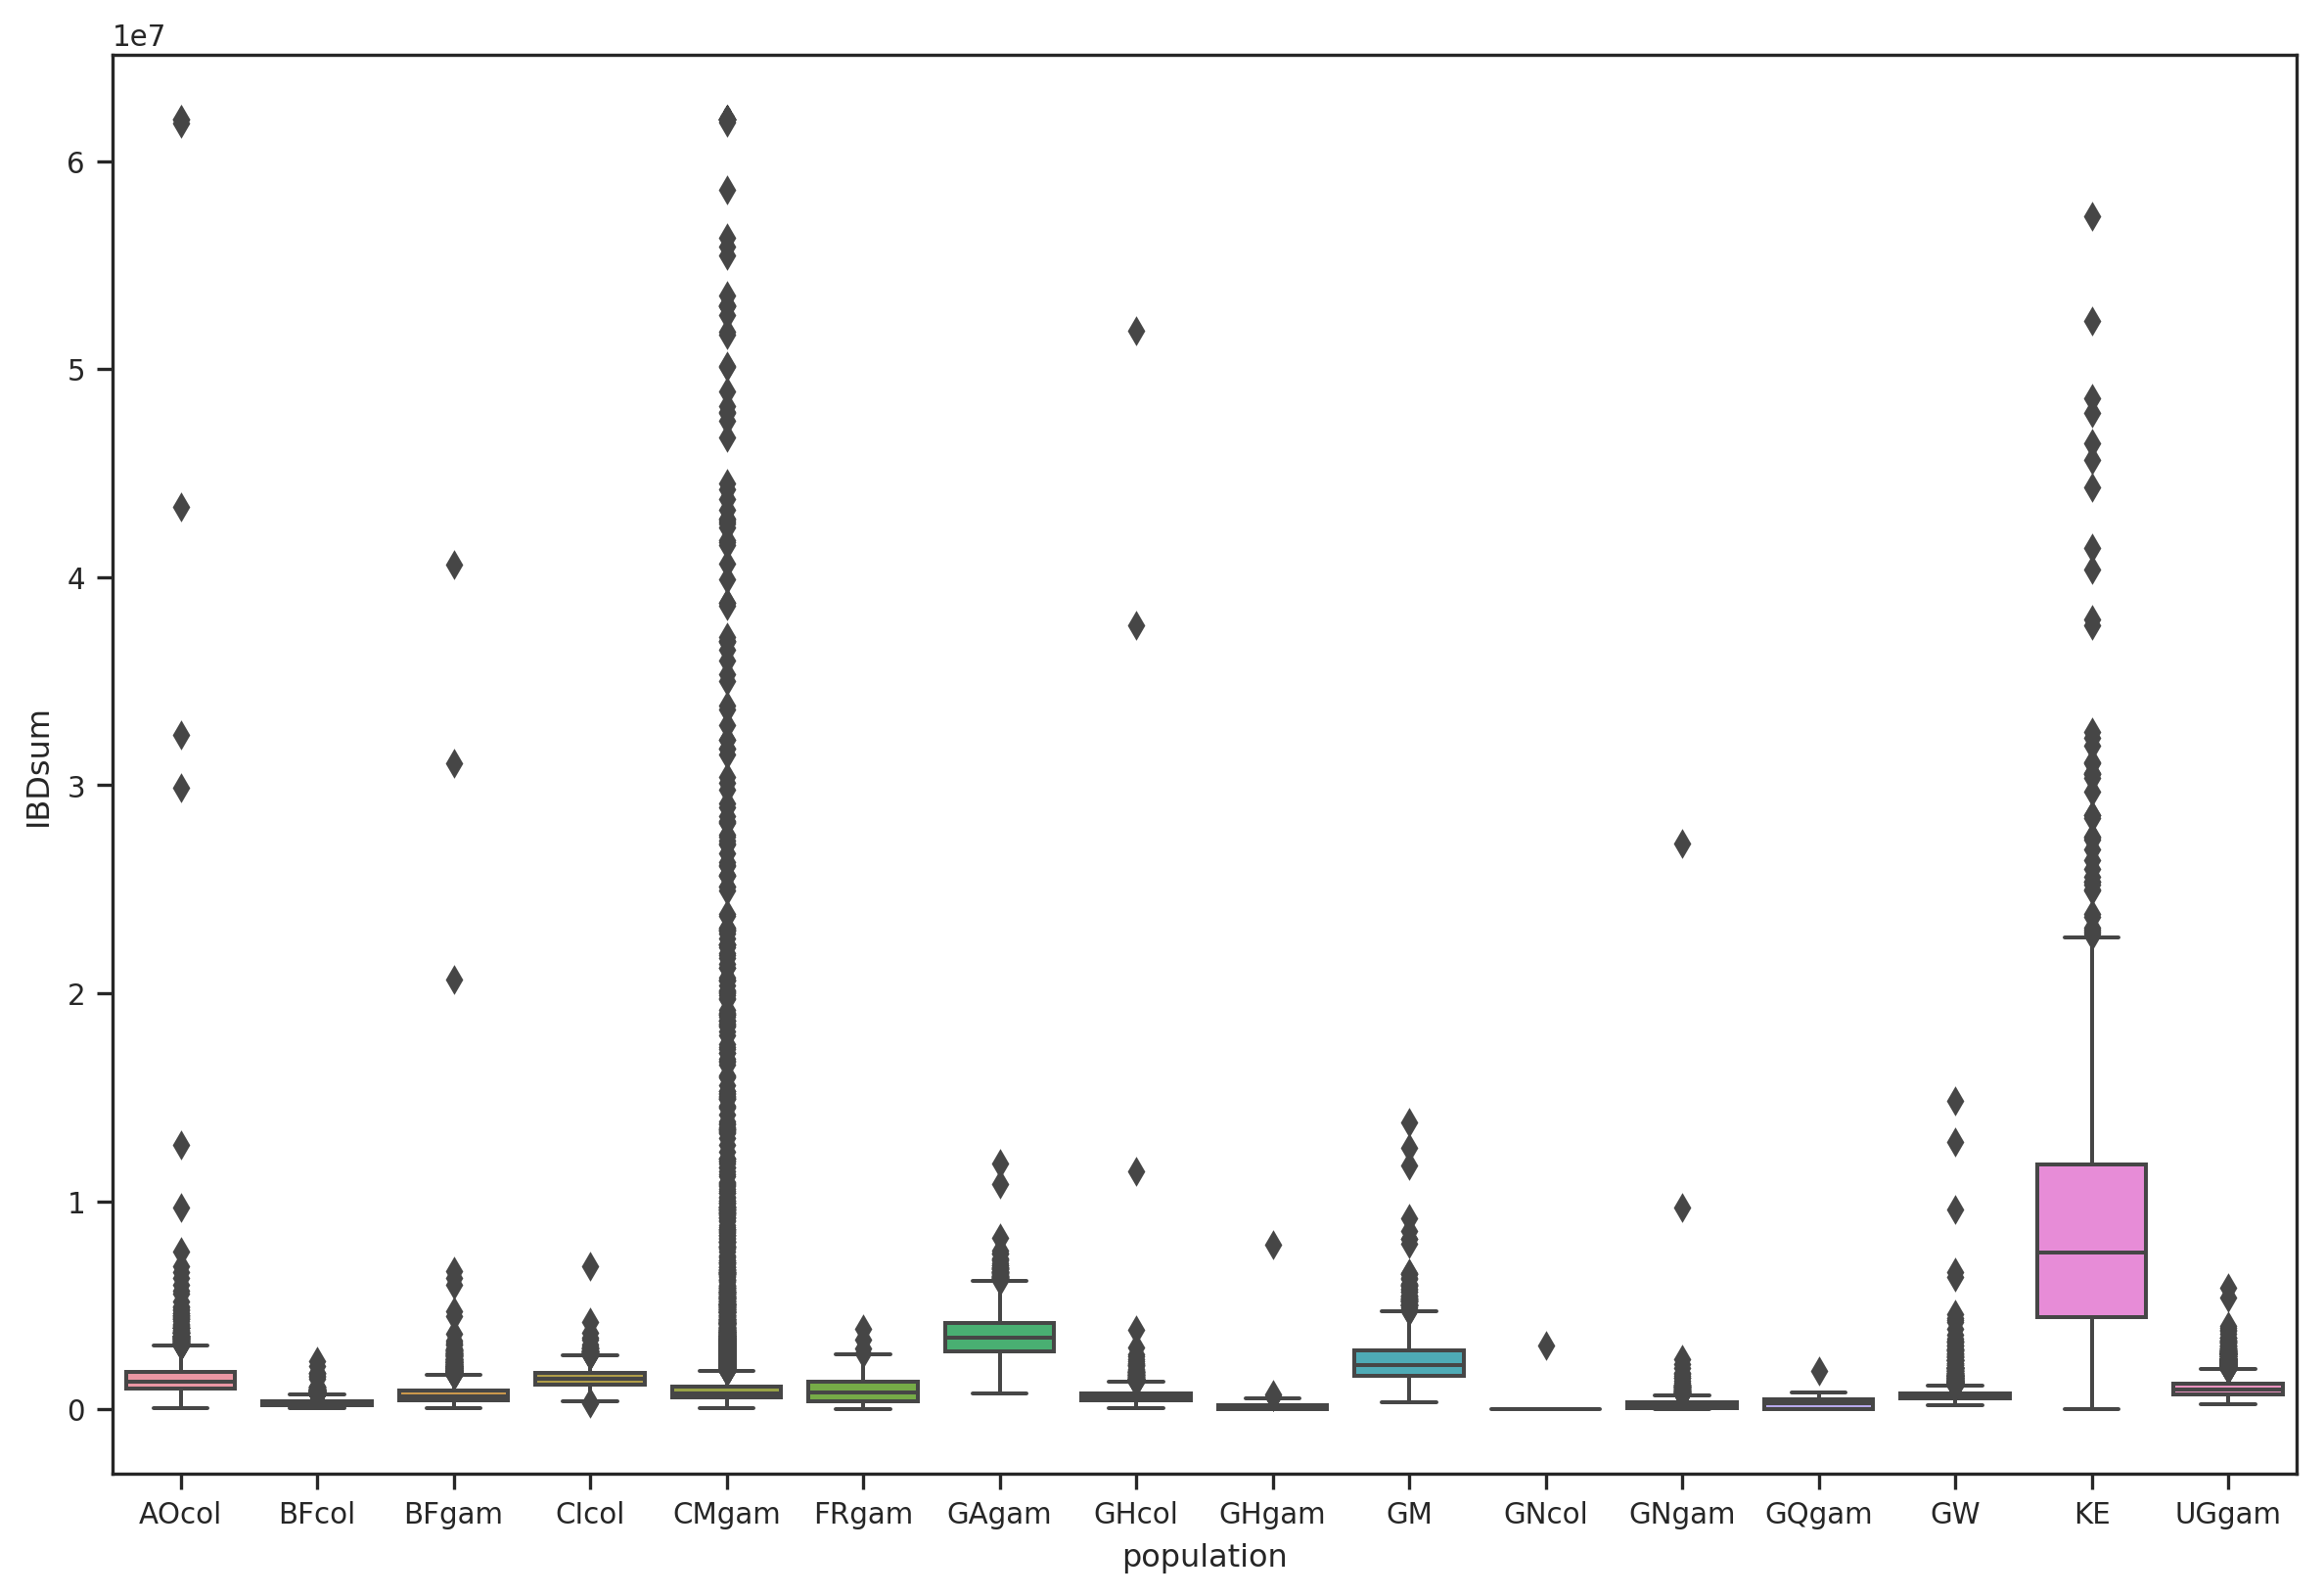

In [21]:
f = plt.figure(figsize=(12, 8))
sns.boxplot(y="IBDsum", x="population", data=all_pop_sum.reset_index())

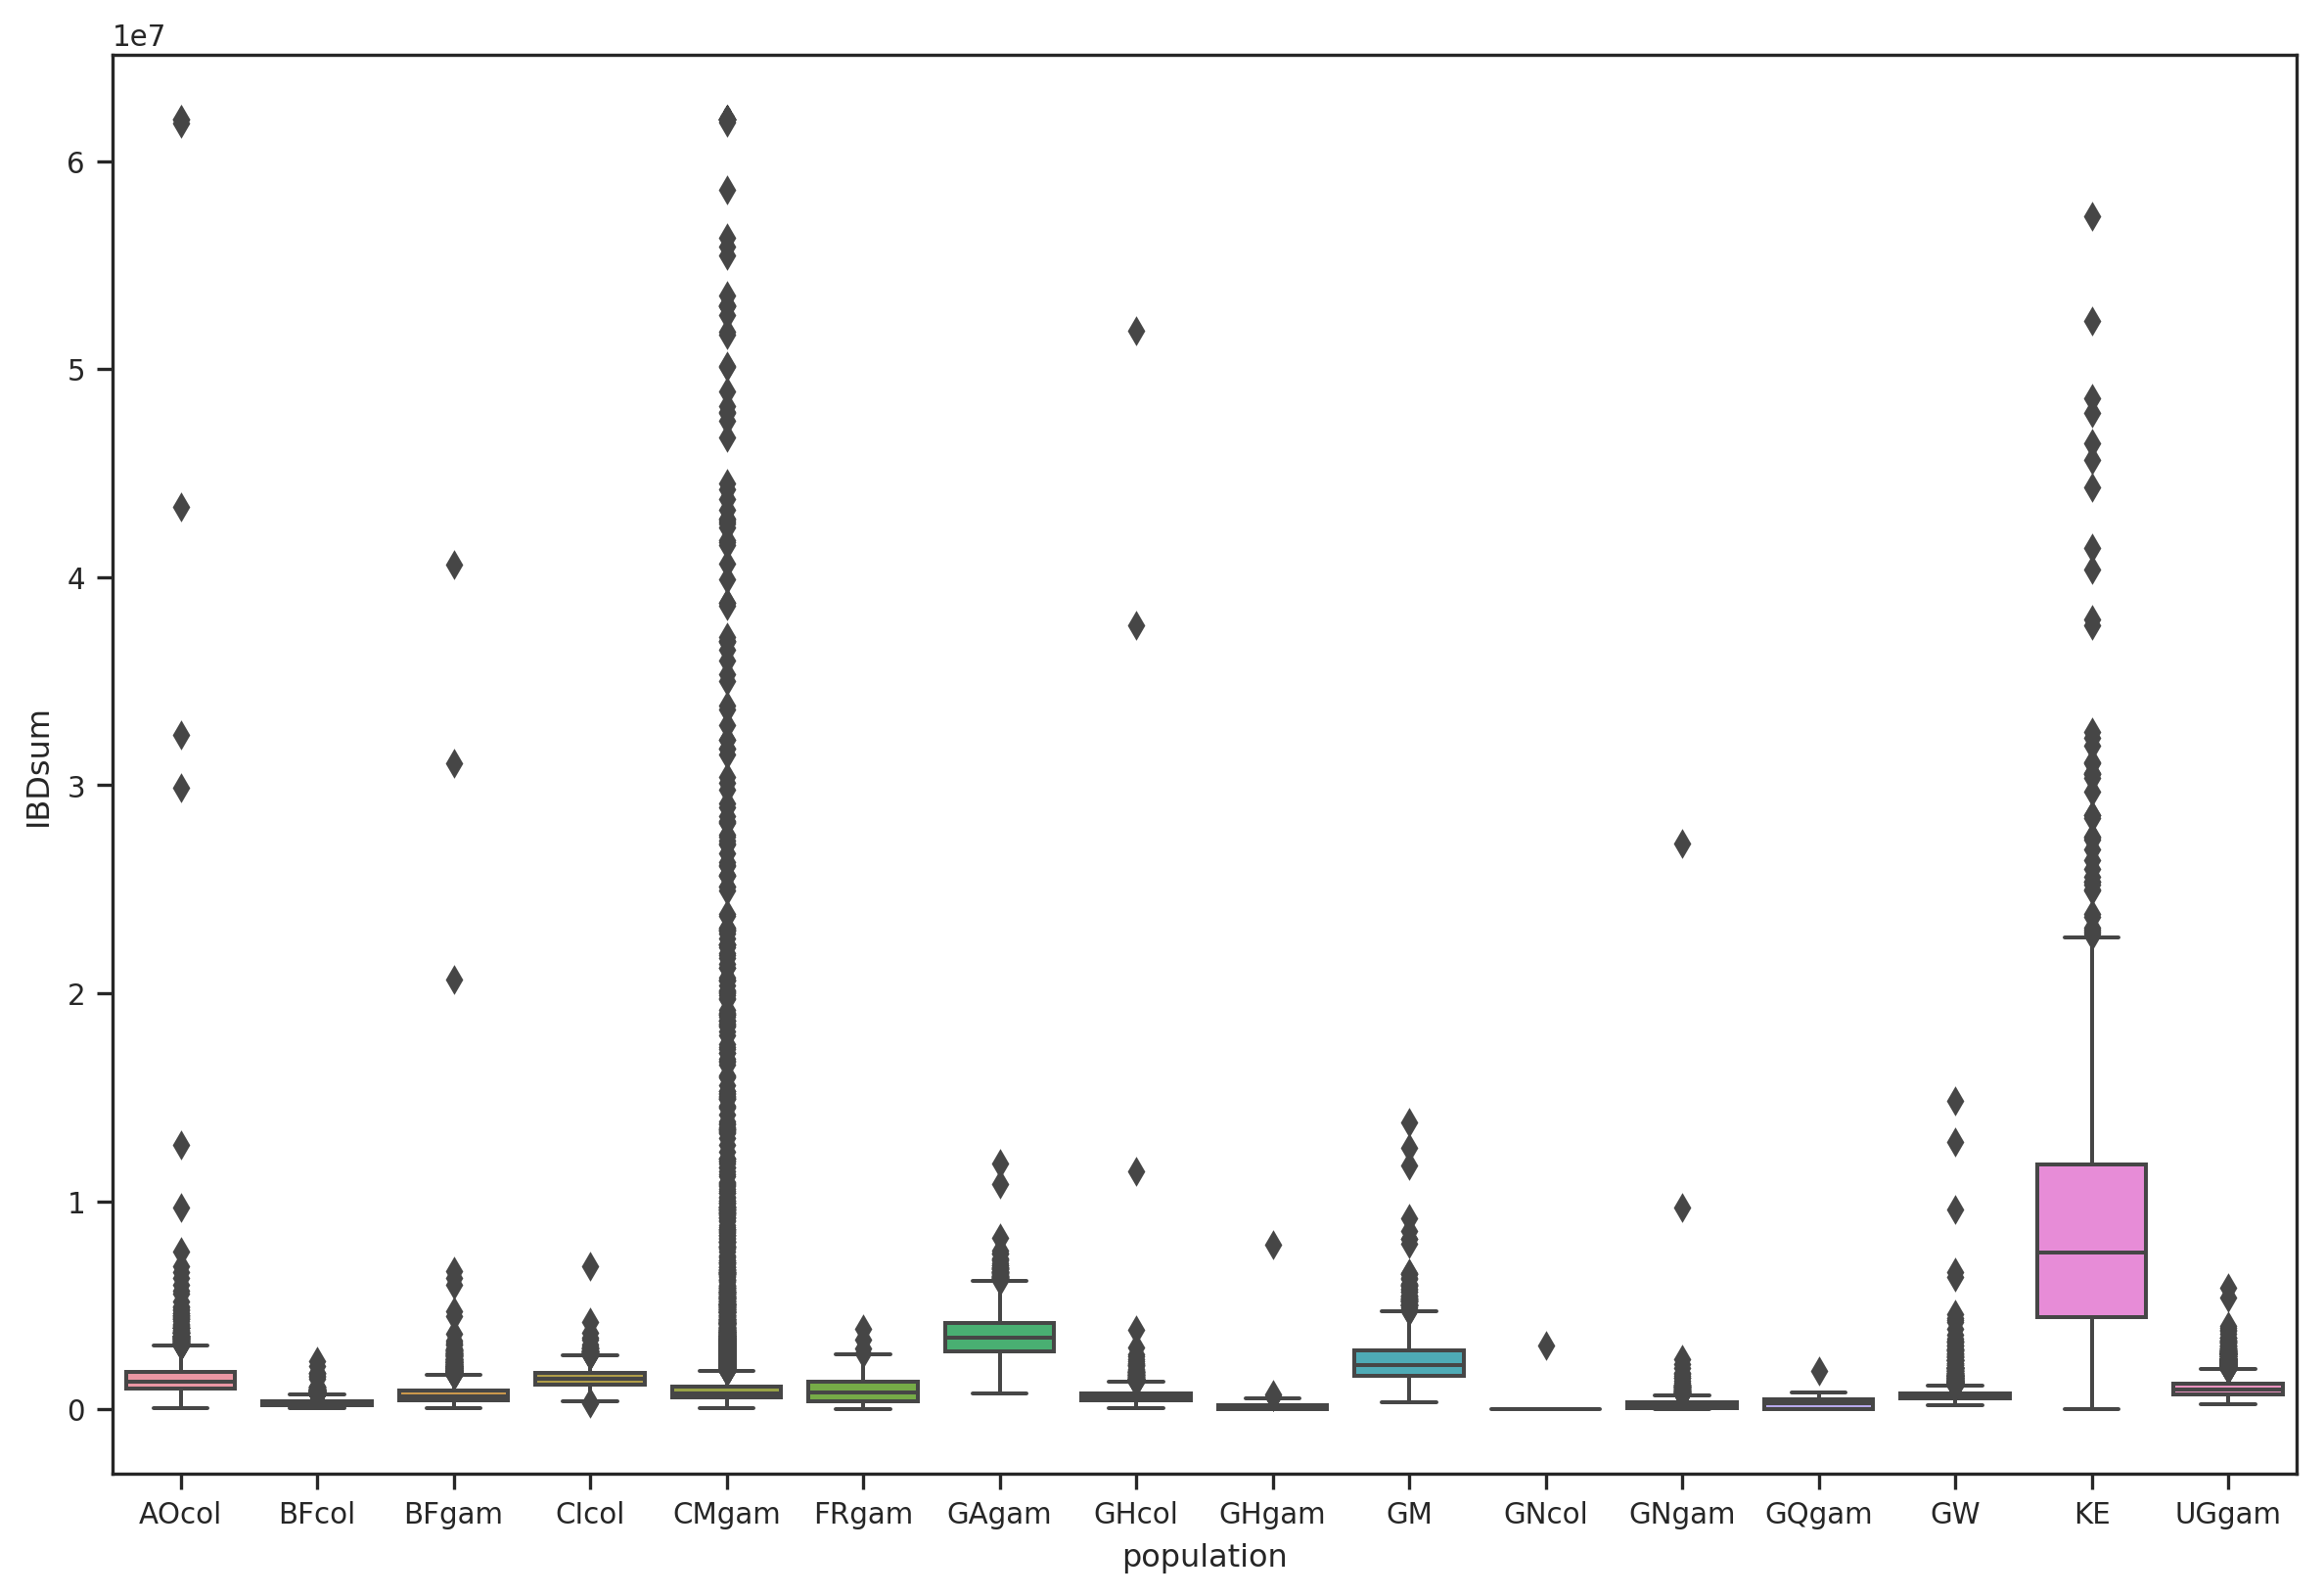

In [22]:
f = plt.figure(figsize=(12, 8))
sns.boxplot(y="IBDsum", x="population", data=all_pop_sum.reset_index())

In [23]:
median_values = all_pop_sum.groupby(level="population").agg(np.median)

In [24]:
sorted_med_ibd = median_values.IBDsum.sort_values(ascending=False)

In [25]:
sorted_med_ibd

population
KE       7512280.0
GAgam    3428489.5
GM       2136311.0
CIcol    1452996.0
AOcol    1341674.0
UGgam     934200.0
FRgam     785521.0
CMgam     770577.0
GW        610253.0
BFgam     608840.5
GHcol     576987.0
BFcol     269093.0
GQgam     265738.0
GNgam     160278.0
GHgam     132385.5
GNcol          0.0
Name: IBDsum, dtype: float64

KE 1000
GAgam 1000
GM 1000
CIcol 1000
AOcol 1000
UGgam 1000
FRgam 276
CMgam 1000
GW 1000
BFgam 1000
GHcol 1000
BFcol 1000
GQgam 36
GNgam 780
GHgam 66
GNcol 6


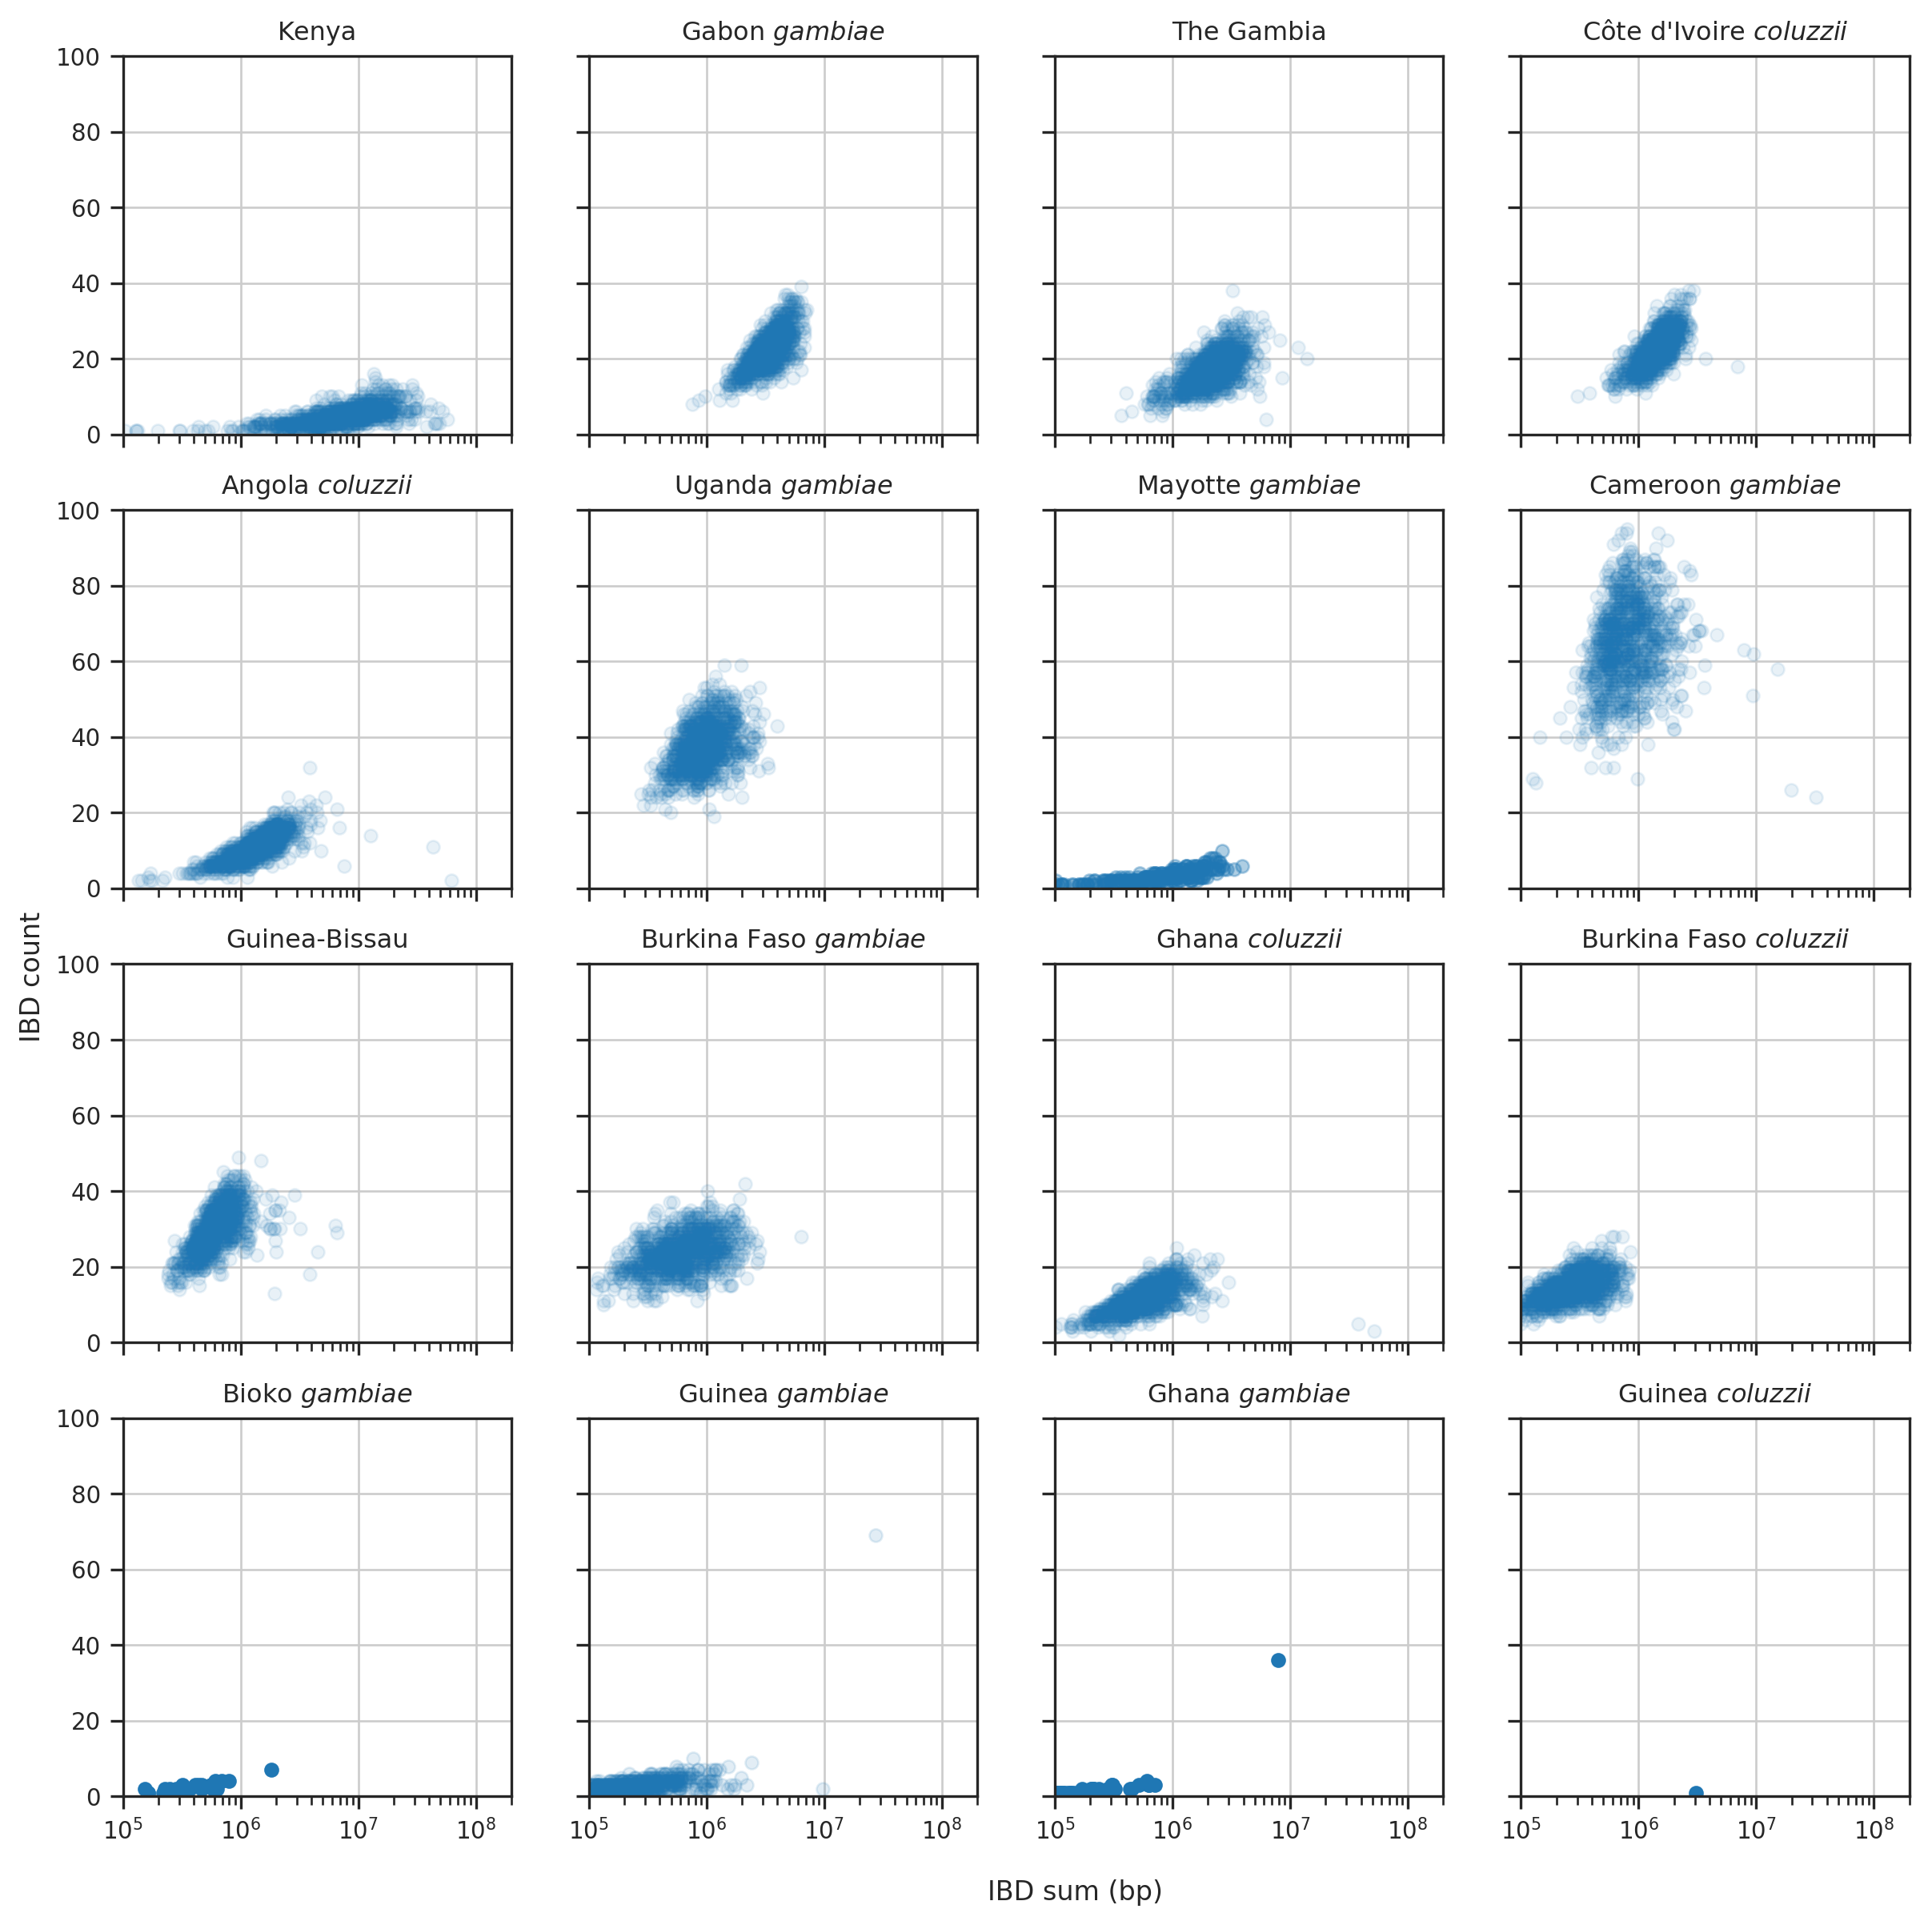

In [26]:
fig, axes = plt.subplots(4, 4, figsize=(12, 12))

for ix, pop in enumerate(sorted_med_ibd.index):
    
    i = (ix // 4)
    j = (ix % 4)
    
    ax = axes[i, j]
    
    ibd = ibd_dict[pop].sample(min(ibd_dict[pop].shape[0], 1000))
    n = ibd.shape[0]
    print(pop, n)
    aph = min(1.0, 100/n)
    ax.scatter(ibd.IBDsum, ibd.IBDcount, alpha=aph)
    ax.set_xscale("log", nonposx='clip')
    ax.set_xlim((10**5, 2 * 10**8))
    ax.set_ylim((0, 100))
    ax.set_title(phase2_ar1.pop_labels[pop])
    ax.grid(True)
    if i < 3:
        ax.set_xticklabels([])
    if j > 0:
        ax.set_yticklabels([])
        
fig.text(0.08, 0.5, rotation=90, s="IBD count")
fig.text(0.5, 0.08, rotation=0, s="IBD sum (bp)")
fig.savefig("../artwork/ibd/ibd_panel_populations.png", bbox_inches="tight", dpi=300)

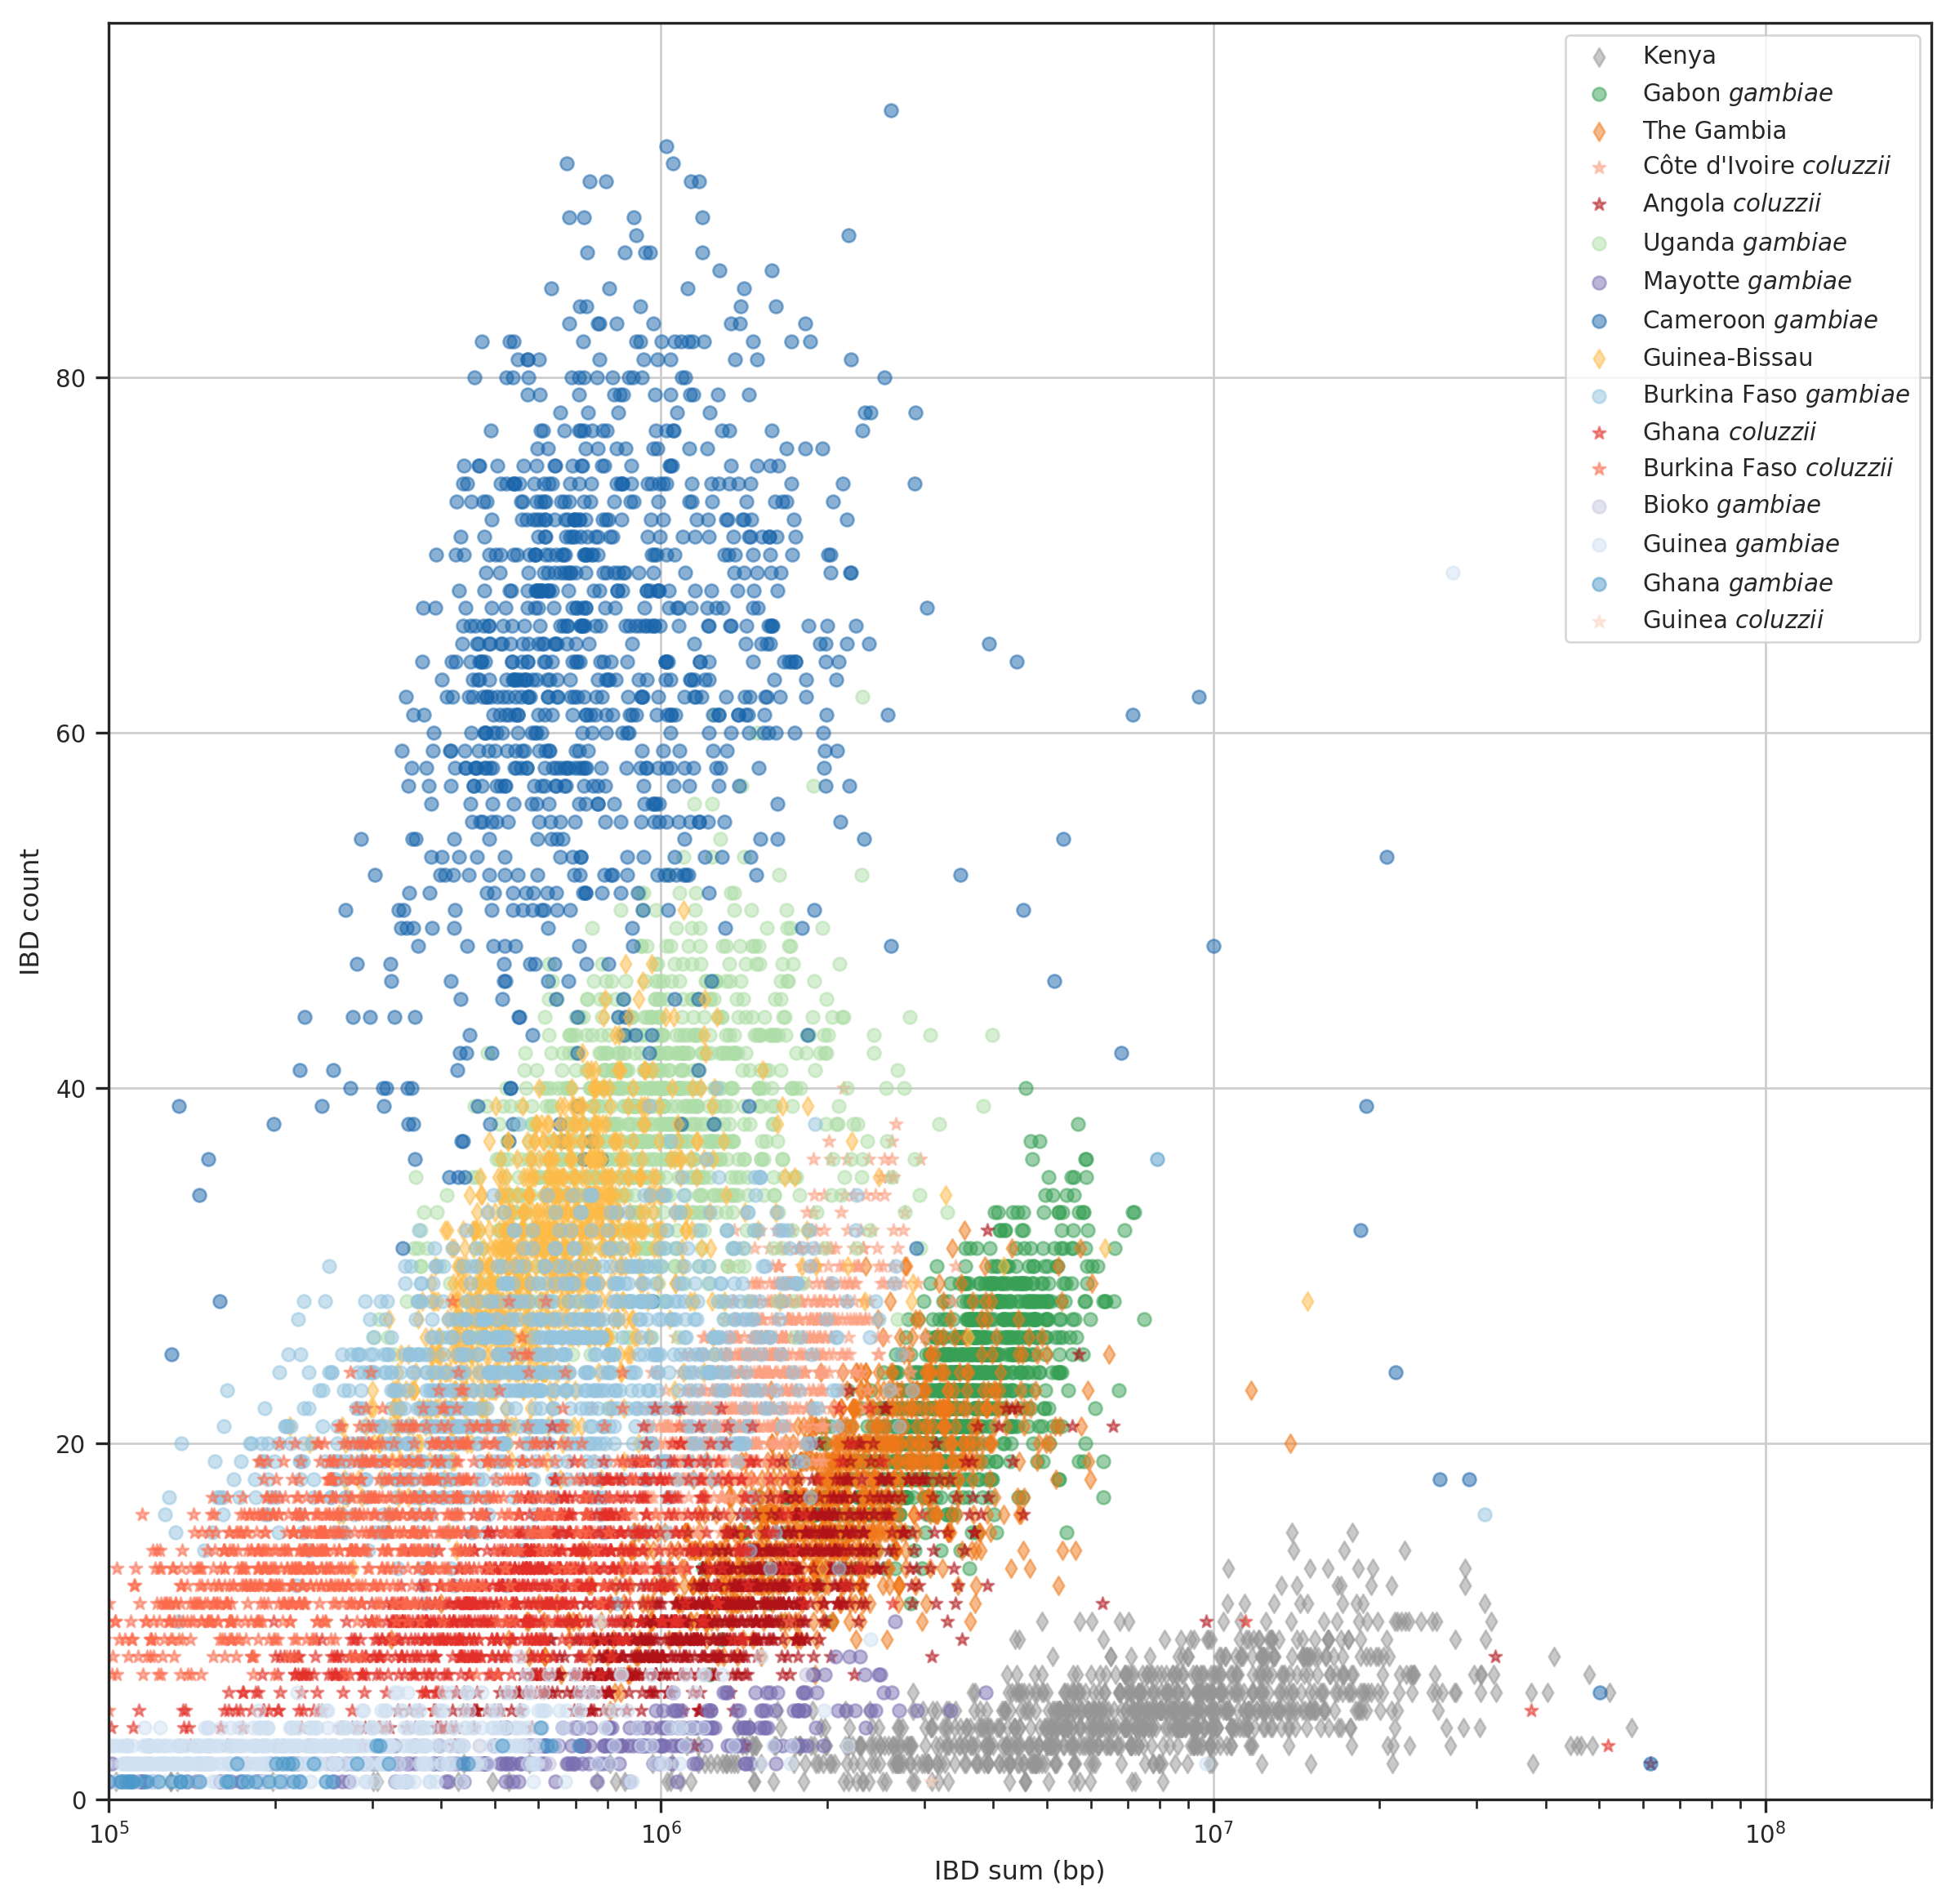

In [27]:
fig, ax = plt.subplots(figsize=(12, 12))

for ix, pop in enumerate(sorted_med_ibd.index):
    
    if pop.endswith("gam"):
        m = "o"
    elif pop.endswith("col"):
        m = "*"
    else:
        m = "d"
    
    
    ibd = ibd_dict[pop].sample(min(ibd_dict[pop].shape[0], 1000))
    ax.scatter(
        ibd.IBDsum, 
        ibd.IBDcount, 
        alpha=0.5, 
        c=(phase2_ar1.pop_colors[pop],),
        marker=m,
        label=phase2_ar1.pop_labels[pop])
    
    ax.set_xscale("log", nonposx='clip')

ax.set_xlim((10**5, 2 * 10**8))
ax.set_ylim(bottom=0)
ax.grid(True)
ax.legend()
ax.set_ylabel("IBD count")
ax.set_xlabel("IBD sum (bp)")
fig.savefig("../artwork/ibd/ibd_all_populations.png", bbox_inches="tight", dpi=300)